In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from matplotlib import gridspec

import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from IPython import display

In [2]:
# 判断是否有GPU

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
"""
    加载数据
    - 模仿的对象
    - 真品
"""

# 加载并预处理图像
data = datasets.MNIST(root="data", 
                      train=True, 
                      transform = transforms.Compose(transforms=[transforms.ToTensor(),
                                                                transforms.Normalize(mean=[0.5], 
                                                                                     std=[0.5])]),
                      download=True)
# 封装成 DataLoader
data_loader = DataLoader(dataset=data, batch_size=100, shuffle=True)

In [4]:
for image, label in data_loader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100])


#### 核心的GAN思想

In [5]:
"""
    定义生成器
"""

class Generator(nn.Module):
    """
        定义一个图像生成
        输入：一个向量(随机噪声，随机数)
        输出：一个向量（代表图像，28 * 28）
    """
    def __init__(self, in_features=128, out_features=28 * 28):
        """
            挂载超参数
        """
        # 先初始化父类，再初始化子类
        super(Generator, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        # 第一个隐藏层
        self.hidden0 = nn.Linear(in_features=self.in_features, out_features=256)
        
        # 第二个隐藏层
        self.hidden1 = nn.Linear(in_features=256, out_features=512)
        
        # 第三个隐藏层
        self.hidden2 = nn.Linear(in_features=512, out_features=self.out_features)
    
    def forward(self, x):
        
        # 第一层 [b, 128] --> [b, 256]
        h = self.hidden0(x)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        
        # 第二层 [b, 256] --> [b, 512]
        h = self.hidden1(h)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        
        # 第三层 [b, 512] --> [b, 28 * 28]
        h = self.hidden2(h)
        
        # 压缩数据的变化范围
        o = torch.tanh(h)
        
        return o

In [6]:
g = Generator()
g

Generator(
  (hidden0): Linear(in_features=128, out_features=256, bias=True)
  (hidden1): Linear(in_features=256, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=784, bias=True)
)

In [7]:
"""
    定义一个鉴别器
"""

class Discriminator(nn.Module):
    """
        本质：二分类分类器
        输入：一个对象
        输出：真品还是赝品
    """
    def __init__(self, in_features=28*28, out_features=1):
        super(Discriminator, self).__init__()
        
        self.in_features=in_features
        self.out_features=out_features
        
        # 第一个隐藏层
        self.hidden0= nn.Linear(in_features=self.in_features, out_features=512)
        
        # 第二个隐藏层
        self.hidden1= nn.Linear(in_features=512, out_features=256)
        
        # 第三个隐藏层
        self.hidden2= nn.Linear(in_features=256, out_features=32)
        
        # 第四个隐藏层
        self.hidden3= nn.Linear(in_features=32, out_features=self.out_features)
        
    
    def forward(self, x):
        
        # 第一层
        h = self.hidden0(x)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        h = F.dropout(input=h, p=0.2)
        
        # 第二层
        h = self.hidden1(h)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        h = F.dropout(input=h, p=0.2)
        
        # 第三层
        h = self.hidden2(h)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        h = F.dropout(input=h, p=0.2)
        
        # 第四层
        h = self.hidden3(h)
        
        # 输出概率
        o = torch.sigmoid(h)
        
        return o

In [8]:
d = Discriminator()
d

Discriminator(
  (hidden0): Linear(in_features=784, out_features=512, bias=True)
  (hidden1): Linear(in_features=512, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=1, bias=True)
)

In [9]:
"""
    构建模型
"""
# 定义一个生成器
generator = Generator(in_features=128, out_features=784)
generator.to(device=device)

# 定义一个鉴别器
discriminator = Discriminator(in_features=784, out_features=1)
discriminator.to(device=device)

Discriminator(
  (hidden0): Linear(in_features=784, out_features=512, bias=True)
  (hidden1): Linear(in_features=512, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=1, bias=True)
)

In [10]:
"""
    定义优化器
"""

# 定义一个生成器的优化器
g_optimizer = torch.optim.Adam(params=generator.parameters(), lr=1e-4)

# 定义一个鉴别的优化器
d_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=1e-4)

In [11]:
"""
    定义一个损失函数
"""
loss_fn = nn.BCELoss()

In [12]:
# 定义训练轮次
num_epochs = 1000

In [13]:
"""
    获取数据的标签
"""

def get_real_data_labels(size):
    """
        获取真实数据的标签（待模仿的数据）
        所有的真实数据标签都是1
    """
    labels = torch.ones(size, 1, device=device)
    
    return labels

def get_fake_data_labels(size):
    """
        获取虚假数据的标签（生成器生成的）
        所有的假数据，标签都是 0
    """
    labels = torch.zeros(size, 1, device=device)
    
    return labels

In [14]:
"""
    噪声生成器
"""
def get_noise(size):
    """
        给生成器准备数据
        - 128维度的向量
    """
    X = torch.randn(size, 128, device=device)
    
    return X

In [15]:
get_noise(16)

tensor([[ 0.7035, -0.8111, -2.4900,  ..., -0.6464,  0.6331, -0.4489],
        [ 0.5030, -0.8843, -0.0699,  ...,  0.7729,  0.7199,  0.3298],
        [-0.9679, -0.1979,  0.8632,  ...,  0.8631, -0.2749, -0.5711],
        ...,
        [-0.1938,  1.1533,  0.4422,  ...,  0.2853,  0.3913, -0.5949],
        [-0.5555, -0.7614, -0.8890,  ...,  0.6492,  0.4755, -0.6436],
        [-1.0538, -0.5677,  0.4047,  ..., -1.2094,  0.7488, -1.1955]],
       device='cuda:0')

In [16]:
# 获取一批测试数据

num_test_samples = 16
test_noise = get_noise(num_test_samples)

In [17]:
test_noise

tensor([[ 1.5485, -1.6386, -0.1702,  ..., -1.4640, -1.0126, -0.8069],
        [ 0.3440, -0.4498, -1.0465,  ...,  1.0047, -0.4676,  2.1257],
        [-0.3004,  0.4766, -0.0169,  ..., -0.5042, -0.3124,  0.3842],
        ...,
        [-0.9603, -0.3229,  0.4839,  ..., -1.5256, -1.3794, -0.6486],
        [-1.1472,  1.1017, -0.2488,  ..., -0.0352,  0.3801,  0.7767],
        [-0.1638, -0.0291,  0.9411,  ..., -0.7695,  1.3742, -0.2904]],
       device='cuda:0')

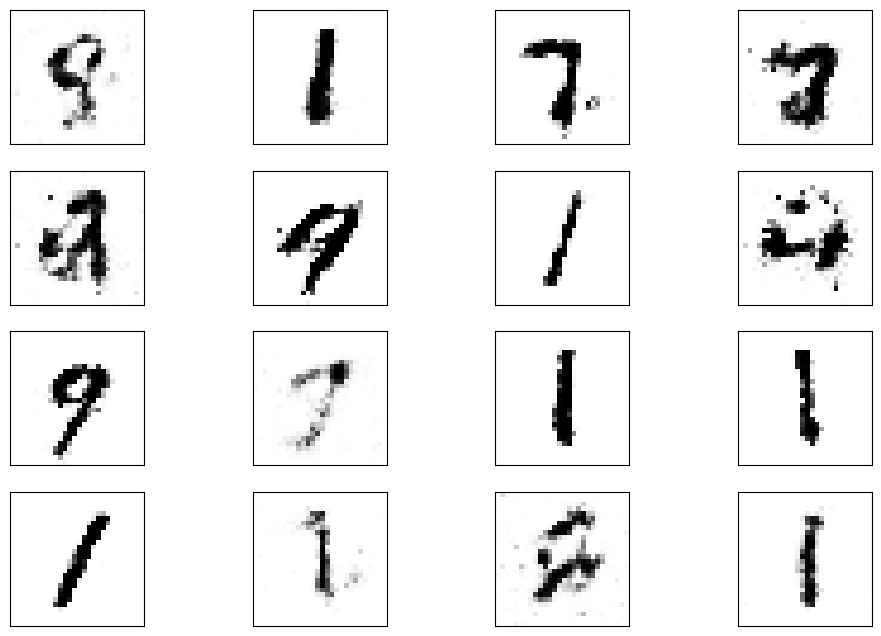

当前正在进行 第 45 轮 ....


KeyboardInterrupt: 

In [18]:
"""
    训练过程
"""
g_losses = []
d_losses = []

for epoch in range(1, num_epochs+1):
    print(f"当前正在进行 第 {epoch} 轮 ....")
    
    # 设置训练模式
    generator.train()
    discriminator.train()
    
    # 遍历真实的图像
    for batch_idx, (batch_real_data, _) in enumerate(data_loader):   
        """
        1, 先训练鉴别器
            鉴别器就是一个二分类问题
            - 给一批真数据，输出真
            - 给一批假数据，输出假
        """
        
        # 1.1 准备数据
        # 图像转向量 [b, 1, 28, 28] ---> [b, 784]
        # 从数据集中获取100个真实的手写数字图像
        real_data = batch_real_data.view(batch_real_data.size(0), -1).to(device=device)
        
        # 噪声[b, 100]
        # 随机生成100个100维度的噪声，用于生成假图像
        noise = get_noise(real_data.size(0))
        
        # 根据噪声，生成假数据 
        # [b, 100] --> [b, 784]
        fake_data = generator(noise).detach()
                
        
        # 1.2 训练过程
        # 鉴别器的优化器梯度情况
        d_optimizer.zero_grad()
        
        # 对真实数据鉴别
        real_pred = discriminator(real_data)
        
        # 计算真实数据的误差
        real_loss = loss_fn(real_pred, get_real_data_labels(real_data.size(0)))
        
        # 真实数据的梯度回传
        real_loss.backward()
        
        # 对假数据鉴别
        fake_pred = discriminator(fake_data)
        
        # 计算假数据的误差
        fake_loss = loss_fn(fake_pred, get_fake_data_labels(fake_data.size(0)))
        
        # 假数据梯度回传
        fake_loss.backward()
        
        # 梯度更新
        d_optimizer.step()

        # ----------------
        
        d_losses.append((real_loss + fake_loss).item())
        
#         print(f"鉴别器的损失:{real_loss + fake_loss}")
        
        """2, 再训练生成器"""
        
        # 获取生成器的生成结果
        fake_pred = generator(get_noise(real_data.size(0)))
        
        # 生产器梯度清空
        g_optimizer.zero_grad()
        
        # 把假数据让鉴别器鉴别一下
        # 把discriminator requires_grad = False
        # 设置为不可学习
        for param in discriminator.parameters():
            param.requires_grad = False
            
        d_pred = discriminator(fake_pred)
        
        # 设置为可学习
        for param in discriminator.parameters():
            param.requires_grad = True
        
        # 计算损失
        # 把一个假东西，给专家看，专家说是真的，这个时候，造假的水平就可以了
        g_loss = loss_fn(d_pred, get_real_data_labels(d_pred.size(0)))
        
        # 梯度回传
        g_loss.backward()
        
        # 参数更新
        g_optimizer.step()
        
#         print(f"生成器误差：{g_loss}")
        g_losses.append(g_loss.item())
   
    # 每轮训练之后，观察生成器的效果
    generator.eval()
    
    with torch.no_grad():
        
        # 正向推理
        img_pred = generator(test_noise)
        img_pred = img_pred.view(img_pred.size(0), 28, 28).cpu().data
        
        # 画图
        display.clear_output(wait=True)
        
        # 设置画图的大小
        fig = plt.figure(1, figsize=(12, 8)) 
        # 划分为 4 x 4 的 网格
        gs = gridspec.GridSpec(4, 4)
        
        # 遍历每一个
        for i in range(4):
            for j in range(4):
                # 取每一个图
                X = img_pred[i * 4 + j, :, :]
                # 添加一个对应网格内的子图
                ax = fig.add_subplot(gs[i, j])
                # 在子图内绘制图像
                ax.matshow(X, cmap=plt.get_cmap("Greys"))
#                 ax.set_xlabel(f"{label}")
                ax.set_xticks(())
                ax.set_yticks(())
        plt.show()
 

In [ ]:
generator

In [ ]:
get_noise(1)

In [ ]:
img = generator(get_noise(1)).detach()

In [ ]:
img

In [ ]:
img1 = ((img * 0.5 + 0.5) * 255).cpu().numpy().astype(int).reshape(28, 28)

In [ ]:
plt.imshow(X=img1, cmap="gray")

In [ ]:
def generate_fake_img():
    with torch.no_grad():
        noise = torch.randn(1, 128).cuda()
        img = generator(noise)
        img = ((img * 0.5 + 0.5) * 255).cpu().numpy().astype(int).reshape(28, 28)
        plt.imshow(X=img, cmap="gray")
        

In [ ]:
generate_fake_img()

In [ ]:
# prompts